# Smart Agent Navigation


This notebook will utilize a Unity ML-Agents environment to train an agent to collect yellow bananas while avoiding blue bananas. [Unity Machine Learning Agents](https://unity3d.com/machine-learning) is an open-source Unity plugin that enables games and simulations to serve as environments for training intelligent agents. Users can train agents on images from this high-fidelity environment, can recieve a state vector (as in this example), or a combination of both.



### 1. Start the Environment

Begin by importing necessary packages.

In [1]:
!pip install unityagents
from unityagents import UnityEnvironment
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install jdc
import jdc

is_ipython = 'inline' in plt.get_backend()

if is_ipython:
    from IPython import display

plt.ion()

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


If GPU available, take advantage of acceleration

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 3. Deep Q-Network

The following cell implements the deep neural network that will be used to approximate the non-linear action-value function for this Banana Collection environment. 

In the paper, the authors implemented a CNN because they defined the input space to be 84 x 84 x 4. This input space consisted of sequential images from the screen, allowing the agent to take advantage of spatial and temporal relationships that a CNN affords.

In this approach, Lunder Lander does not return an image of a screen, but a 1-dimentional state vector. As such, a fully connected neural network will be utilized. 

In [6]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # fully connected layers. Notice how weight parameters are not being given. I am relying on PyTorch to 
        # initialize these for me.
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        # output layer
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        # utilize rectified linear units as activation functions for each neuron
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 4. Replay Buffer

Mnih et al. implemented a Replay Buffer to address several issues present with standard online Q-Learning applied to this environment:

1) Each step of experience is potentially used in several update steps. This experience tuple can be a rare occurance/edge case and thus the agent can learn from these cases more often without having to rely on the hope of experiencing the rare occurance in the environment. 

2) There are strong correlations between consequtive frames in this environment. That is to say, an action at time step T will affect the state at timestep T+1, which in turn affects the state at timestep T+2, and so on. An agent that relies solely on sequential learning runs the risk of being stuck in a local minimum or divering catastrophically. 

### 5. Decoupling 

3) When learning sequentially and on-policy (weights are updating every iteration), the current parameters determine the next data sample that these same parameters are trained on. This is the literal equivalent of aiming at a moving target. Replay Buffers allow a decoupling between the target and the parameters that are being changed to obtain this target when weights are kept fixed over N number of iterations. This concept is known as a Fixed Q-Target.

In sum, having a replay buffer than contains prior experiences and learns from these experiences only after a certain number of iterations addresses the most salient issues present when adapting Q-Learning for this application. 

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer. keep N number of the most recent experiences.
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

###   6. The Agent 

The following cells define the Agent class, which implements the salient features of the above paper. These include Experience Replay and Fixed Q-Targets. For more information on these concepts, please refer to the paper. Specifically, the 'Methods' section.

In [8]:
class Agent(object):

    def __init__(self, state_size, action_size, seed=0, buffer_size=int(1e5), 
                 batch_size=64, gamma=0.99, tau=1e-3, learning_rate=5e-4, update_rate=4):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            buffer_size(int): reply buffer size
            batch_size(int): minibatch size
            gamma(float): discount factor
            tau(float): utilized in the soft update of target parameters
            lr(float): learning rate
            update_rate(int): defines how often the network weights are updated
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.learning_rate = learning_rate
        self.update_rate = update_rate
        
        # Q-Network. As described in "decoupling" above, weights must be kept frozen for a certain number of iterations.
        # This interval is defined by the paramters "update_rate". Q-Network implementation uses two networks to "freeze"
        # weights while new experiences are collected.
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        
        # Initialize time step for updating every 'update_rate' frequency
        self.t_step = 0
        

The Banana Collector program provides a vector of the current state. The agent accepts this state and inputs the state into the Q-Network, which produces an action. Notice that no learning is done at this point.

The following cell describes this how the agent implements this concept. 

In [9]:
%%add_to Agent

def act(self, state, eps=0.):
    """Returns actions for given state per current policy.

    Params
    ======
        state (array_like): current state
        eps (float): epsilon, for epsilon-greedy action selection. 
        
    Note
    =====
    For more information on what an epsilon-greedy action policy is, view the SARSA directory elsewhere in my github.
    """
    
    # convert numpy to pyTorch tensor
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    
    # change the network to evaluation mode
    self.qnetwork_local.eval()
    
    # disable gradient calculation in autograd. When disabled, autograd does not store the actions performed
    # on the forward pass (which are used for gradient calculation with backward() is called).
    with torch.no_grad():
        
        # obtain action values for this state produced by the network
        action_values = self.qnetwork_local(state)
        
    # change mode to training
    self.qnetwork_local.train()

    # Epsilon-greedy action selection
    if random.random() > eps:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(self.action_size))

After receiving the action produced by the Q-Network, the Agent will progress the environment by calling *env.step(action)*. 

This call will return a new state vector that represents the updated environment, as well as a reward for performing that action.

The agent will use this State, Action, Reward, Next_State experience to add to its Replay Buffer. In addition, the Agent will "learn" - update Q-Network weights - if the interval defined by 'update_rate' has been hit.

In [10]:
%%add_to Agent

def step(self, state, action, reward, next_state, done):
        
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)

    # Learn every 'update_rate' time steps.
    self.t_step = (self.t_step + 1) % self.update_rate

    if self.t_step == 0:

        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > self.batch_size:

            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

If the learning interval has been reached, the Agent will update weights. The following cell implements the concepts discussed above under the section *Replay Experience* and *Decoupling*. In essence, keeps one set of weights fixed during N number of iterations allows a decoupling of the variable weights in the network and the target Q-value that these weights are attempting to approximate. By decoupling these values, the network does not introduce a moving target. 

For more information on this concept, please read the paper listed above.

### 7.Double Q-Network

Hasselt, et al. (2015) introduced Double Deep Q-Learning Network that aims to address the overestimation present in standard Q-Learning and Deep Q-Network, such as that seen in my implementation of the DQN algorithm in this Github. 

**The following learn() function from the DQN has been modified to incorporate the Double DQN approach.**

In this approach, the local network identifies the action (a') that results in the max q-value for a next state (s').
Then, the target network obtains this action and finds the maximum state-action (s', a') q-value. This Q(s',a') value is used to calculate the TD error that the network is trained on. 

By decoupling the action selection from the max state-action q-value, the network is shown to train faster and perform more effectively. 

In [11]:
%%add_to Agent
def learn(self, experiences, gamma):
    """Update value parameters using given batch of experience tuples.

    Params
    ======
        experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
    """
    
    states, actions, rewards, next_states, dones = experiences
    
    # Obtain the local-network predicted q-values for actions taken on the next_state.
        
    # change local network to inference mode. The aim here is to have the local network predict q-values for actions, not
    # to learn.
    self.qnetwork_local.eval()
    
    # disable gradient calculation in autograd. When disabled, autograd does not store the actions performed
    # on the forward pass (which are used for gradient calculation with backward() is called).
    with torch.no_grad():
        
        """
         obtain action values for this state produced by the network.
         the resulting vector is a (bs x 1) in shape, were bs is the batch size.
         the scalar values are integers representing the action that produced the maximum q-value.
         The argmax() call isolates 1st dimesion and returns the index corresponding to the largest value.
         In this case, the 1st dimension is an array of q-values for all actions in the action space.
        """
        next_state_action_values_localNet = self.qnetwork_local(next_states).argmax(1).unsqueeze(1)
        
        
    # change mode to training
    self.qnetwork_local.train()
    
    """
     Obtain the target-network predicted q-values for actions taken on the next_state.
     detach() will produce a new tensor that is separated from the network. 
     gather() will extract the 1st dimension of the tensor, which correspond to the arrays of action values. 
     next_state_action_values_localNet identifies what index to obtain from the array of action values.
     Again, this index corresponds to the action with the maximum estimated q-value by the local network.
    """
    Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, next_state_action_values_localNet)
    
    """
     Compute Q targets for current states. 
     When done[i] equals 1, the Q_target is the reward. This is consistent behavior with reinforcement learning applications
     for the end state.
    
     At this point, the implementation of DDQN is complete, as the decoupled Q(s,a) has been obtained. 
    """
    Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        

    # Get expected Q values from local model
    
    """
    qnetwork_local(states) returns a (bs x action_size) shaped tensor. For example, result.shape = 64x4, where result[0]
    returns an array of length 4 corresponding to the various actions that can be taken in this environment and their
    associated q-value. that is, result[0][0] = -0.47 for action ==> 0 ==> 'boost right'.
    
    gather(1, will operate on the 1st dimension, which corresponds to the arrays themselves.
    'actions' is a (bs x 1) shaped vector (vertical vector), where each entry corresponds to the action that was taken. 
    that is, actions[5] = 3 for action 'boost left'. 
    gather(1,actions) will filter on the first dimension and pick the index of the array given by the corresponding entry
    in the actions vector. this will return a (bs x 1) shaped vector where the scalar value is 
    the q-value of the action that was taken.
    
    Notice that detach is not called. so, autograd will record the operations performed in order to calculate gradients.
    """
    Q_expected = self.qnetwork_local(states).gather(1, actions)

    # Compute loss
    loss = F.mse_loss(Q_expected, Q_targets)
    
    # Minimize the loss
    # zero out the autograd so that prior gradient calculations are not incorporated into this pass.
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # update TARGET network by setting new weight values within the network.
    self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau) 

A soft update is performed when updating the values of the target network. Tau specifies the degree to which the new value reflects the original value. This is seen by the multiplication of (tau) and (1-tau) in the update step.

In [12]:
%%add_to Agent

def soft_update(self, local_model, target_model, tau):
    """Soft update model parameters.

    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """

    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):

        # the 'underline' character indicates that this action is to be performed on the variable itself,
        # rather than on a copy of the variable.
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

###  8. Train the Agent

At this point, all the pieces are present to begin training the Agent in the Banana Collector environment using a Deep Q-Network.

The following cell is very similar in structure to the function seen elsewhere in my github (for Discretization and SARSA) that interacts with the OpenAI Gym environment and the Agent. As such, I won't explain much here, as that has been done in other notebooks within my Github under Reinforcement Learning.

Episode 100	Average Score: 0.73
Episode 200	Average Score: 4.12
Episode 300	Average Score: 8.77
Episode 400	Average Score: 11.19
Episode 500	Average Score: 12.89
Episode 600	Average Score: 14.10
Episode 644	Average Score: 15.02
Environment solved in 544 episodes!	Average Score: 15.02


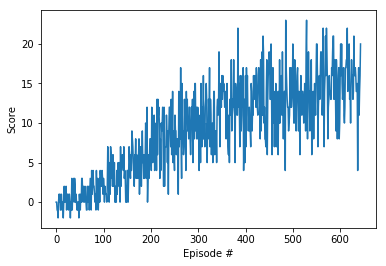

In [13]:
def deep_Q_learning(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            
            action = int(agent.act(state, eps))
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            if done:
                break 
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon. For more information on the importance of epsilon 
                                          # to an agent's action policy, see the SARSA directory in this Github.
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window)>=15.0:
            
            # a mean score >= 13 represents a solved state. At this point, training has been complete.
            # save the network weights for future testing.
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'banana_collect_ddqn.pth')
            break
            
    return scores

agent = Agent(state_size=37, action_size=4, seed=0)
scores = deep_Q_learning()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 9. Watch the Smart Agent Collect Bananas!

The following code will utilize the trained network to successfully collect yellow bananas, while avoiding blue bananas.

In [14]:
env_info = env.reset(train_mode=False)[brain_name]             # reset the environment
state = env_info.vector_observations[0]                        # get the current state
score = 0                                                      # initialize the score
agent_test = Agent(state_size=37, action_size=4, seed=0)       # initialize smart agent and load trained weights
agent_test.qnetwork_local.load_state_dict(torch.load('banana_collect_ddqn.pth'))

while True:
    
    action = int(agent_test.act(state))        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 18.0


When finished, close the environment.

In [15]:
env.close()